California House Price Prediction

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_housing_data():
    datasets_dir = Path("datasets")
    datasets_dir.mkdir(exist_ok=True)
    tarball_path = datasets_dir / "housing.tgz"
    if not tarball_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path=datasets_dir)
    return pd.read_csv(datasets_dir/"housing/housing.csv")

housing = load_housing_data()

In [ ]:
housing.info()

In [ ]:
housing["ocean_proximity"].value_counts()

In [ ]:
housing.head(50)

In [ ]:
housing.describe()

In [ ]:
housing[(housing["population"] >= 450) & (housing["median_income"] >= 5)]

Ploting Histogram of the Data

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(20, 15), tight_layout=True)

ax[0, 0].hist(housing["longitude"], bins=50, edgecolor="black", label="Longitude")
ax[0, 1].hist(housing["latitude"], bins=50, edgecolor="black", label="Latitude")
ax[0, 2].hist(housing["housing_median_age"], bins=50, edgecolor="black", label="Housing median age", )

ax[1, 0].hist(housing["total_rooms"], bins=50, edgecolor="black", label="Total rooms")
ax[1, 1].hist(housing["total_bedrooms"], bins=50, edgecolor="black", label="Total bedrooms")
ax[1, 2].hist(housing["population"], bins=50, edgecolor="black", label="Population")

ax[2, 0].hist(housing["households"], bins=50, edgecolor="black", label="Households")
ax[2, 1].hist(housing["median_income"], bins=50, edgecolor="black", label="Median income")
ax[2, 2].hist(housing["median_house_value"], bins=50, edgecolor="black", label="Median income")

for i in range(3):
    for j in range(3):
        ax[i, j].legend()
        ax[i, j].set_title(housing.columns[i * 3 + j])
        ax[i, j].grid(True)
plt.show()


# OR just run the code below

# housing.hist(bins=50, edgecolor="black")
# plt.show()

Creating a Test Set

In [ ]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(housing, 0.2)
    

In [ ]:
len(train_set), len(test_set)

In [ ]:
from zlib import crc32


def is_id_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Using Sklearn for Spliting the data for training and testing

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
test_set["total_bedrooms"].isnull().sum()

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.title("Number of districts by income category")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    strat_splits.append([strat_train_set, strat_test_set])
    
strat_train_set, strat_test_set = strat_splits[0]


In [ ]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [ ]:
housing = strat_train_set.copy()

Visualizing the Data

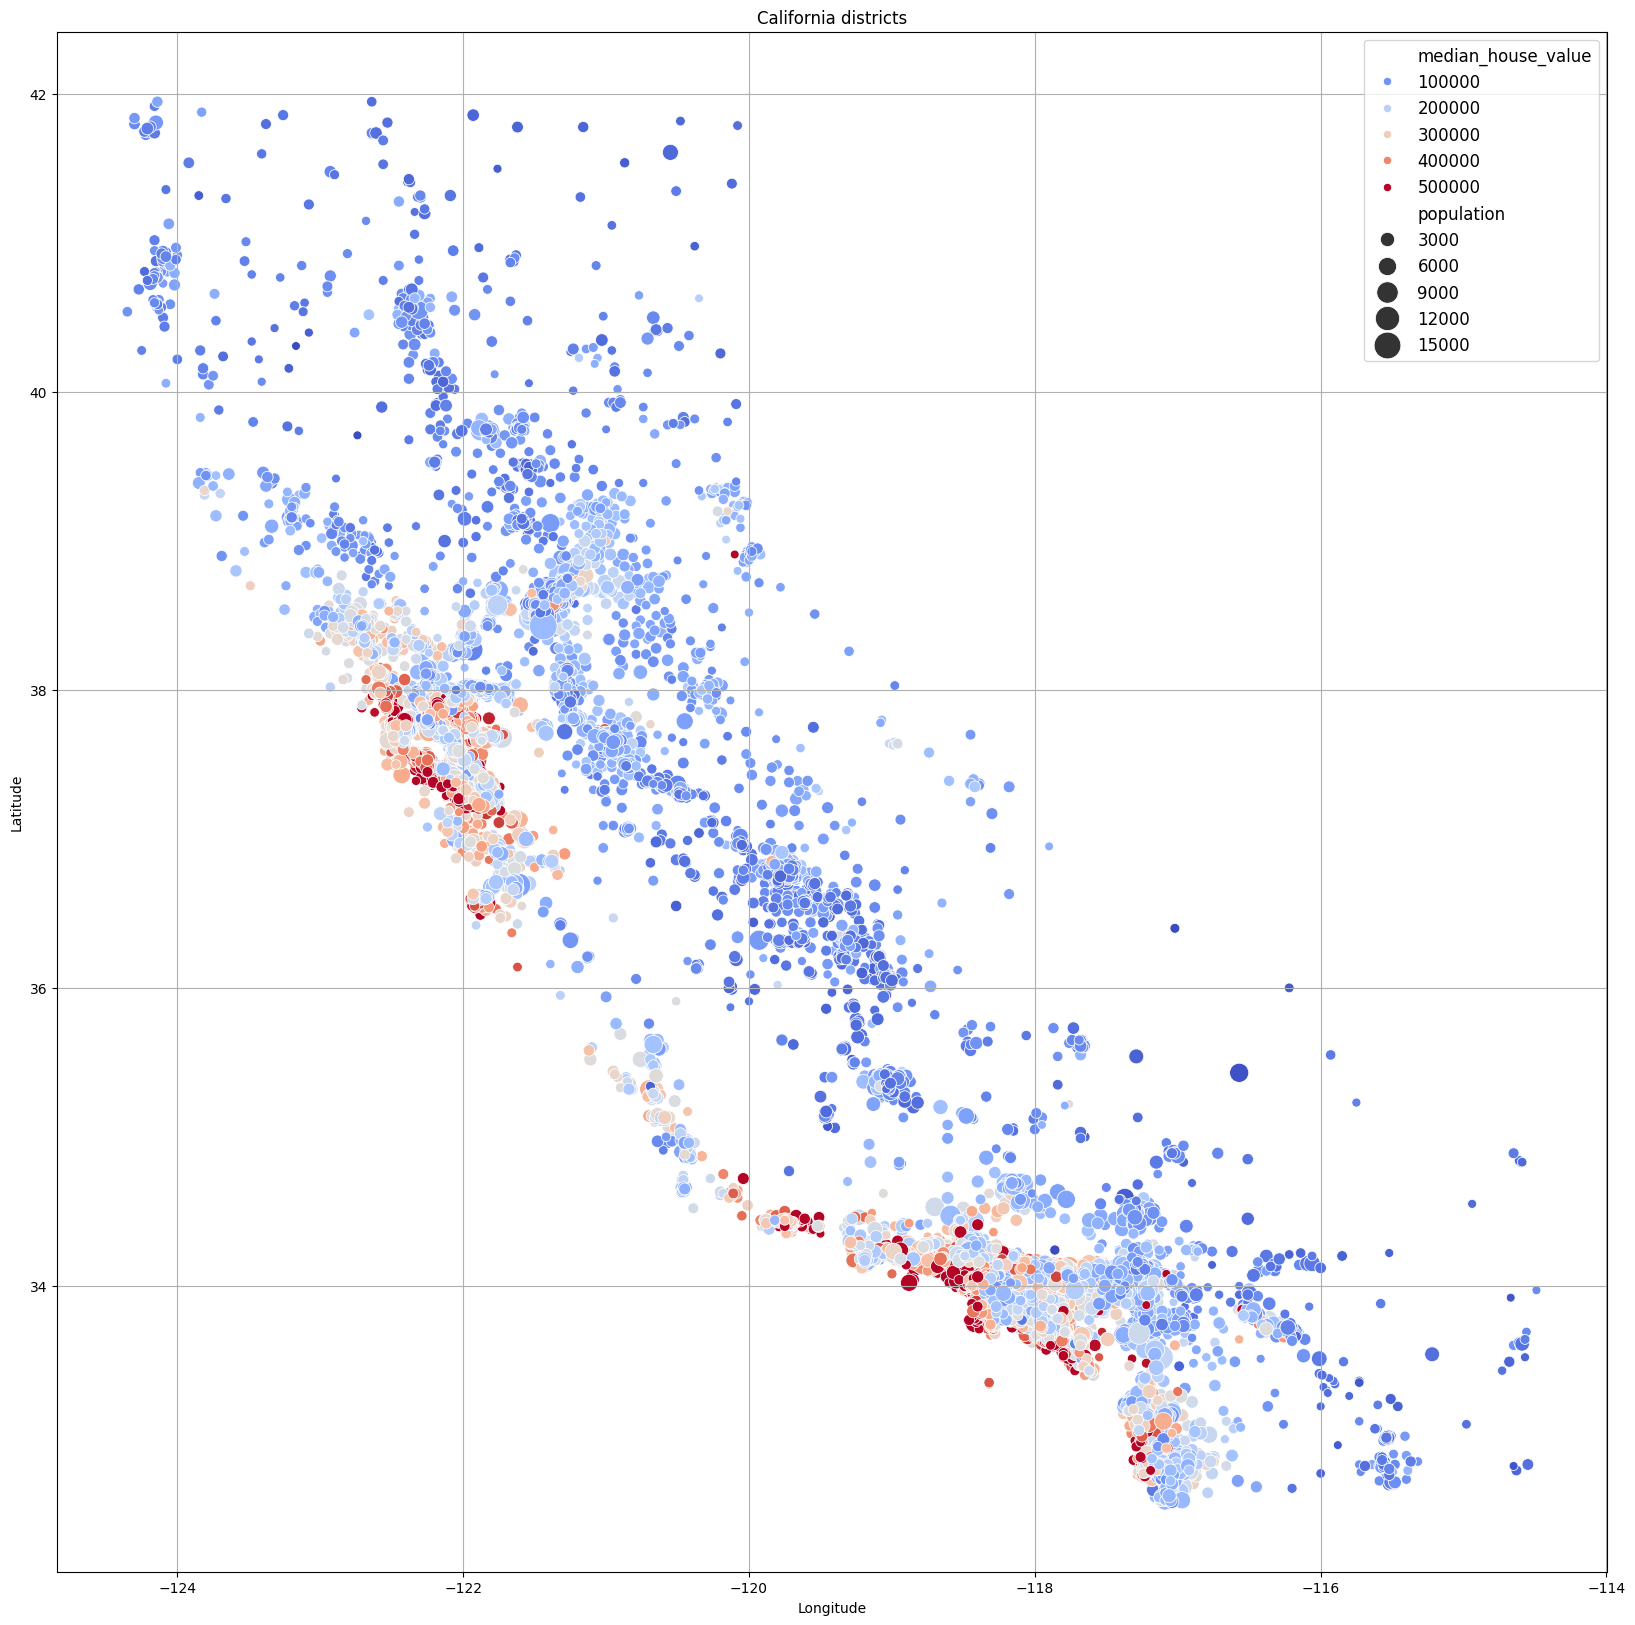

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))

sns.scatterplot(
    data=housing,
    x='longitude',
    y='latitude',
    hue='median_house_value',
    size='population',
    sizes=(40, 400),
    palette='coolwarm',
    )

ax.set(xlabel='Longitude', ylabel='Latitude', title='California districts')
plt.legend(bbox_to_anchor=(1, 1),  fontsize=12)
plt.grid(True)